In [4]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


Using TensorFlow backend.


In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
# by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [17]:

def plot_results(models,data,batch_size=128,model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    filename = os.path.join(model_name, "digits_over_latent.png")
# display a 30x30 2D manifold of digits
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


In [12]:

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [13]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m","--mse",help=help_, action='store_true')
    args = parser.parse_args()
    models = (encoder, decoder)
    data = (x_test, y_test)
# VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae,
    to_file='vae_mlp.png',
    show_shapes=True)
    if args.weights:
        vae.load_weights(args.weights)
    else:
# train the autoencoder
        vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
        vae.save_weights('vae_mlp_mnist.h5')
    plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")

usage: ipykernel_launcher.py [-h] [-w WEIGHTS] [-m]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/kushalgoenka/Library/Jupyter/runtime/kernel-685416d5-df25-4096-96ac-84dc50231ebc.json


SystemExit: 2

/Users/kushalgoenka/anaconda3/envs/CS498AML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 15s 249us/step - loss: 51.7448 - val_loss: 43.7967
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 43.1922 - val_loss: 42.4303
Epoch 3/50
60000/60000 [==============================] - 7s 118us/step - loss: 42.2265 - val_loss: 41.6729
Epoch 4/50
60000/60000 [=

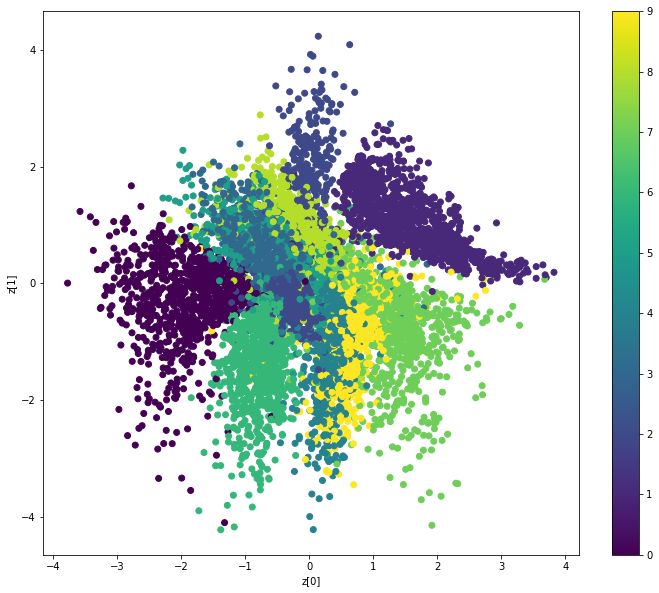

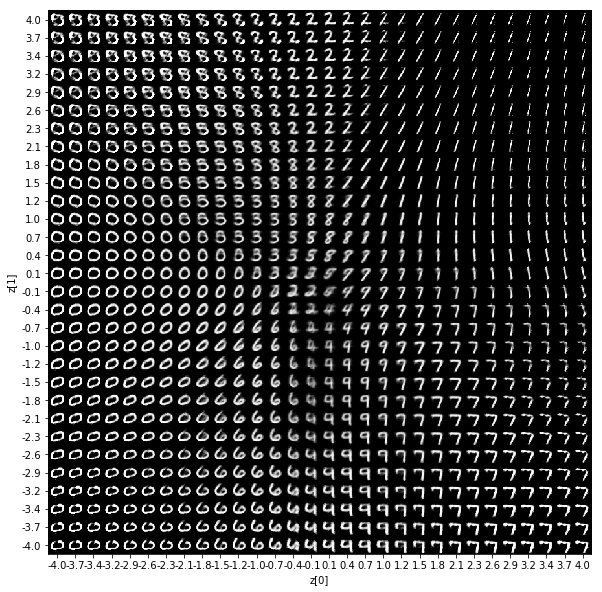

In [15]:
models = (encoder, decoder)
data = (x_test, y_test)
# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)
# if args.weights:
#     vae.load_weights(args.weights)
# else:
# # train the autoencoder
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")

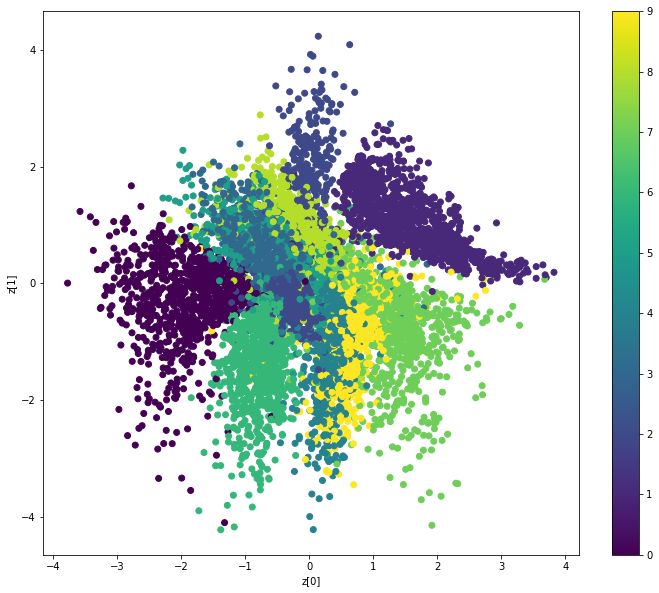

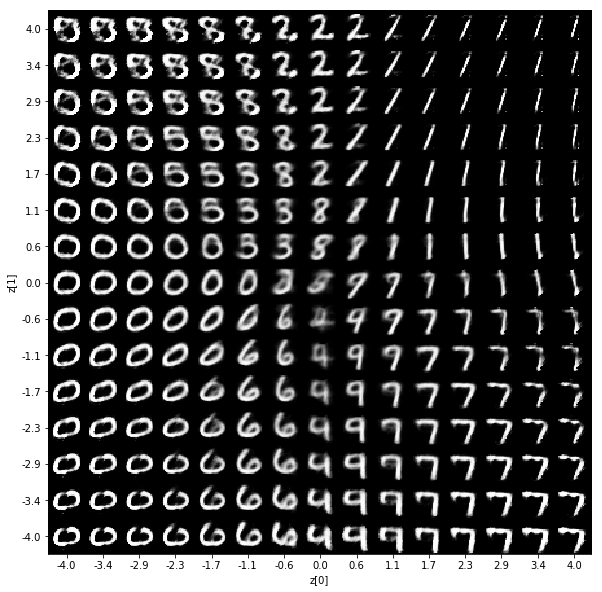

In [18]:
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")

In [62]:

def plot_results(models,data,batch_size=128,model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,batch_size=batch_size)
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.savefig(filename)
#     plt.show()
#     print(z_mean)
    filename = os.path.join(model_name, "digits_over_latent.png")
# display a 30x30 2D manifold of digits
    n = 2
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            print(xi,yi)
            z_sample = np.array([[xi, yi]])
            print(z_sample)
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

-4.0 4.0
[[-4.  4.]]
4.0 4.0
[[4. 4.]]
-4.0 -4.0
[[-4. -4.]]
4.0 -4.0
[[ 4. -4.]]


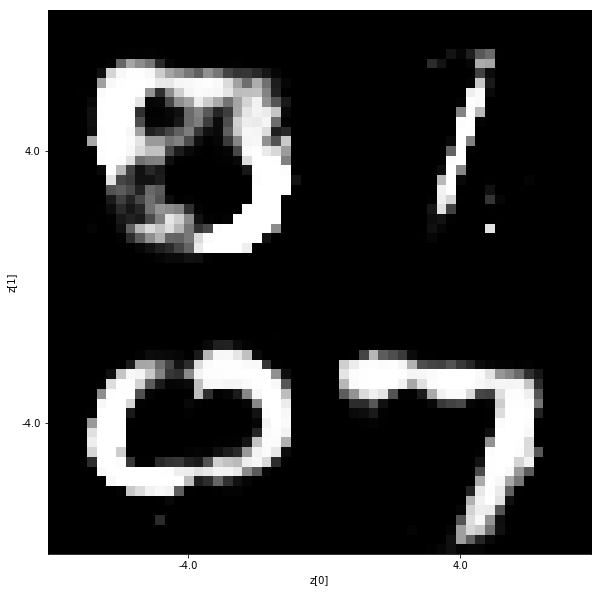

In [63]:
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")

In [35]:
y_test[0]

7

In [160]:
m= encoder.predict(x_test)

In [161]:
x_test[0].shape

(784,)

In [162]:
,

''

In [163]:
np.shape(m)

(3, 10000, 2)

In [164]:
m

[array([[ 1.3668911 , -0.6555393 ],
        [ 0.08693141,  1.5736195 ],
        [ 1.7004842 ,  1.7153584 ],
        ...,
        [ 0.6976868 , -0.33208454],
        [ 0.10992527,  0.15930499],
        [-1.1994994 , -1.1924652 ]], dtype=float32),
 array([[-4.297833 , -4.469276 ],
        [-4.438859 , -3.0548916],
        [-3.709012 , -3.6275697],
        ...,
        [-5.336786 , -5.200439 ],
        [-5.555942 , -4.87649  ],
        [-5.5280952, -5.1010194]], dtype=float32),
 array([[ 1.4630512 , -0.7900025 ],
        [ 0.03337348,  1.6523008 ],
        [ 1.7729814 ,  1.7635247 ],
        ...,
        [ 0.8218418 , -0.2827393 ],
        [ 0.11714236,  0.1715742 ],
        [-1.1576622 , -1.3142715 ]], dtype=float32)]

In [149]:
m[0]

array([[ 1.3668914 , -0.6555394 ],
       [ 0.08693132,  1.5736195 ]], dtype=float32)

In [143]:
m

[array([[ 1.366891 , -0.6555393]], dtype=float32),
 array([[-4.297833, -4.469276]], dtype=float32),
 array([[ 1.5359954, -0.7460627]], dtype=float32)]

In [129]:
np.shape(m[0])

(2,)

In [165]:
x_decoded = decoder.predict(m[0])
digit = x_decoded[1].reshape(28, 28)

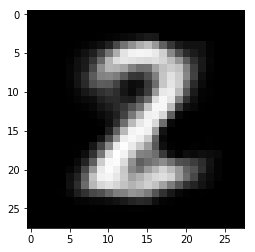

In [166]:
plt.imshow(digit, cmap='Greys_r')

Encoded is codes

In [182]:
which = 21
y_test[which]

6

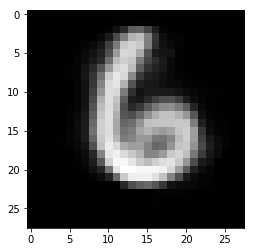

In [183]:
digit = x_decoded[which].reshape(28, 28)
plt.imshow(digit, cmap='Greys_r')

In [266]:
import numpy as np
import random

numbers = [0,1,2,3,4,5,6,7,8,9]
largeCodesArr =[]
for num in numbers:
    firstidx = random.choice(np.argwhere(np.array(y_test)==num))
    second = random.choice(np.argwhere(np.array(y_test)==num))
    first = x_test[firstidx]
    second = x_test[second]
    codeFirst = encoder.predict(first)[0]
    codeSecond = encoder.predict(second)[0]
    diff = codeSecond-codeFirst
    diffdiff = diff/8
    allCodes = []
#     allCodes.append(codeFirst)
    for i in range(0,9):
        temp = codeFirst+(i*diffdiff)
        allCodes.append(temp)
#     allCodes.append(codeSecond)
    largeCodesArr.append(allCodes)
#     decodedFirst = decoder.predict(codeFirst[0])

In [267]:
largeCodesArr[9]

[array([[ 1.1322993 , -0.20106487]], dtype=float32),
 array([[ 1.0650685 , -0.32278067]], dtype=float32),
 array([[ 0.99783766, -0.44449645]], dtype=float32),
 array([[ 0.93060684, -0.56621224]], dtype=float32),
 array([[ 0.863376, -0.687928]], dtype=float32),
 array([[ 0.7961452 , -0.80964386]], dtype=float32),
 array([[ 0.7289144 , -0.93135965]], dtype=float32),
 array([[ 0.66168356, -1.0530754 ]], dtype=float32),
 array([[ 0.59445274, -1.1747912 ]], dtype=float32)]

In [268]:
codeFirst

array([[ 1.1322993 , -0.20106487]], dtype=float32)

In [269]:
codeSecond

array([[ 0.59445274, -1.1747912 ]], dtype=float32)

In [233]:
firstdigit = decoder.predict(largeCodesArr[1][7])

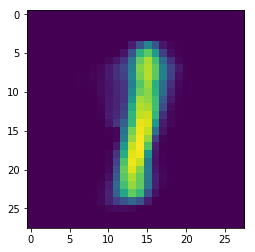

In [234]:
plt.imshow(firstdigit.reshape(28,28))

In [217]:
for a in largeCodesArr[0]:
    print(a)

[[-1.3067513   0.12769979]]
[[-1.3600839  0.1428044]]
[[-1.3600839  0.1428044]]
[[-1.3600839  0.1428044]]
[[-1.3600839  0.1428044]]
[[-1.3600839  0.1428044]]
[[-1.3600839  0.1428044]]
[[-1.3600839  0.1428044]]
[[-1.6800803   0.23343202]]


In [209]:
codeSecond[0]-codeFirst[0]

array([[-2.290657 ,  1.9798349]], dtype=float32)

In [207]:
codeFirst[0]

array([[ 0.85652626, -0.9576788 ]], dtype=float32)

In [208]:
codeSecond[0]

array([[-1.4341309,  1.0221561]], dtype=float32)

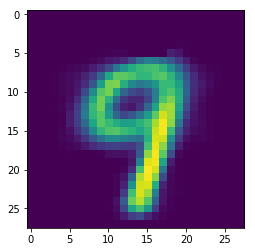

In [201]:
plt.imshow(decodedFirst.reshape(28,28))

In [186]:
y_test[8228]

0

In [189]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [193]:
codeFirst[0]

array([[ 1.2583594 , -0.24859394]], dtype=float32)

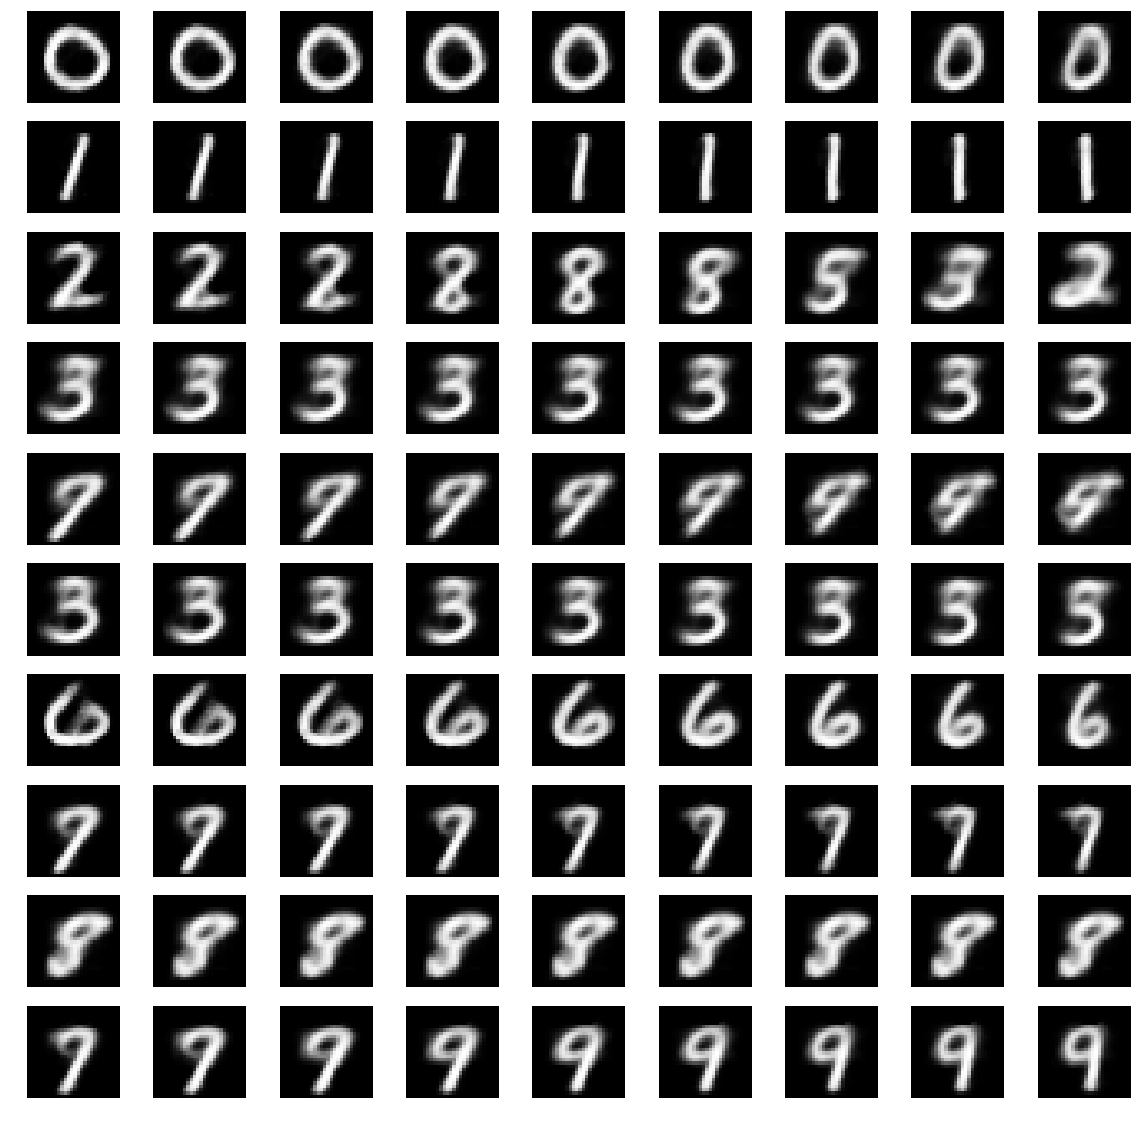

In [275]:
f,ax = plt.subplots(10,9,figsize=(20,20))
plt.axis('off')


for i,num in enumerate(largeCodesArr,0):
    for j,digit in enumerate(num,0):
        decoded = decoder.predict(digit)
        ax[i,j].imshow(decoded.reshape(28,28),cmap='Greys_r')
#         plt.show()
        ax[i,j].axis('off')
    

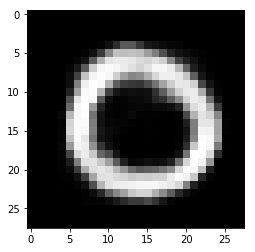

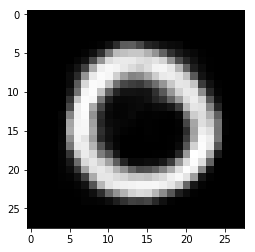

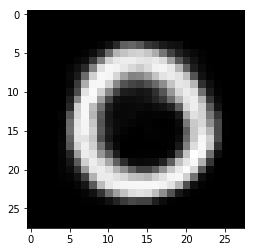

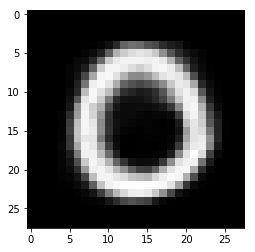

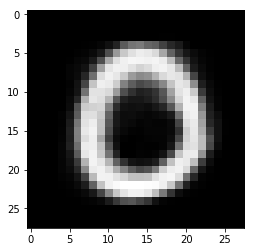

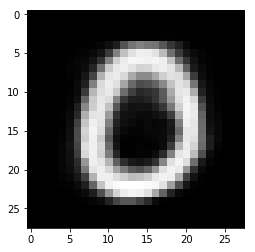

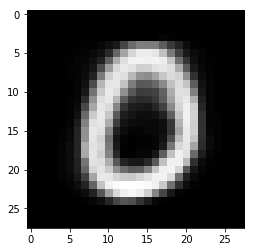

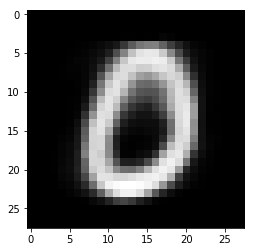

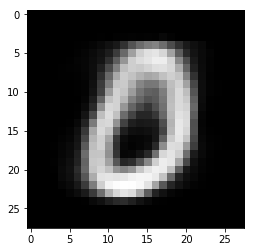

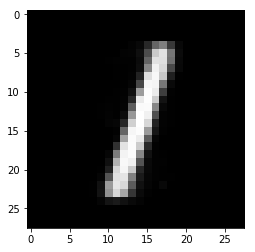

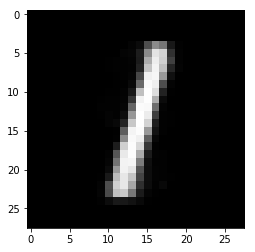

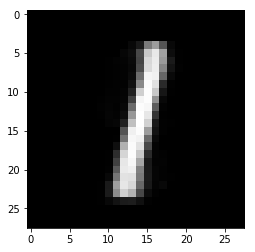

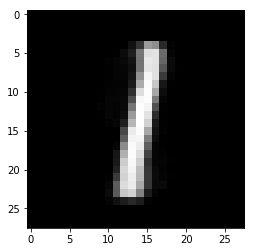

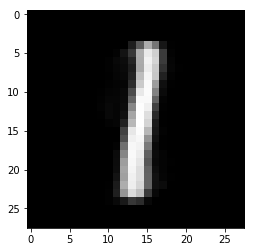

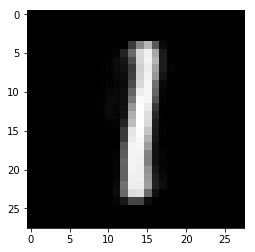

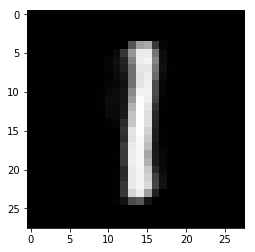

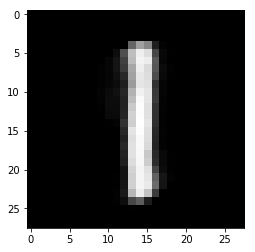

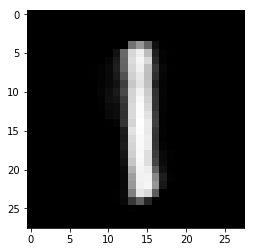

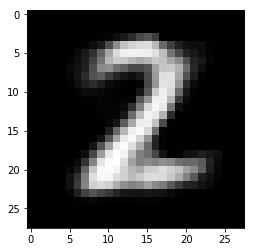

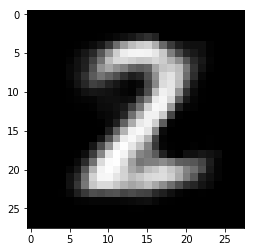

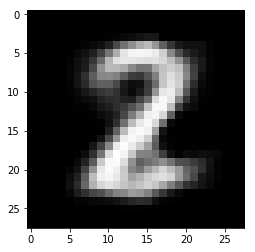

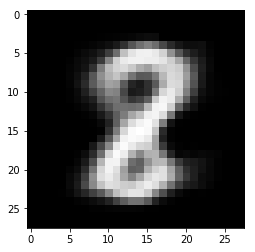

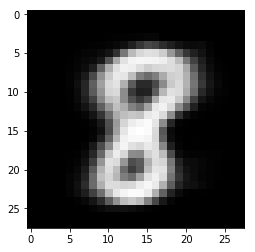

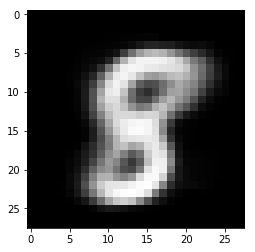

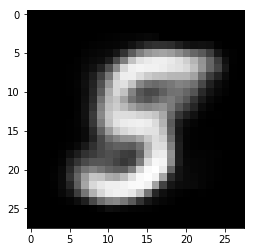

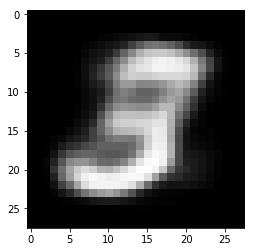

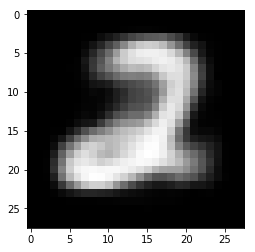

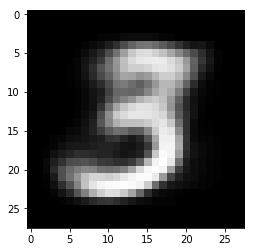

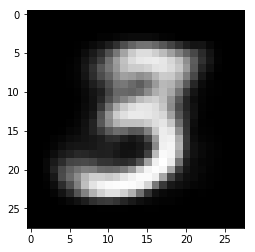

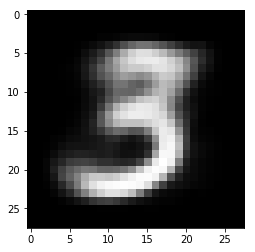

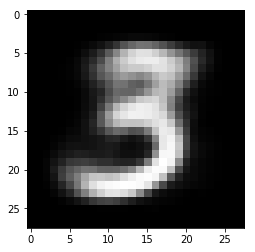

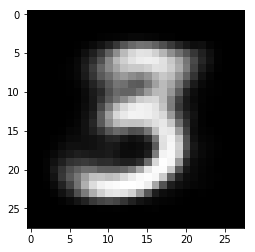

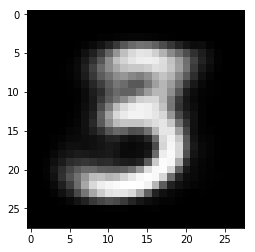

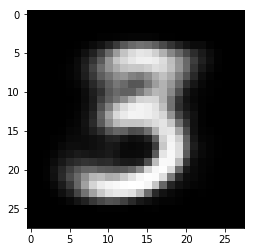

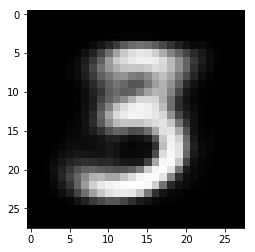

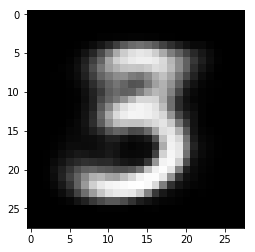

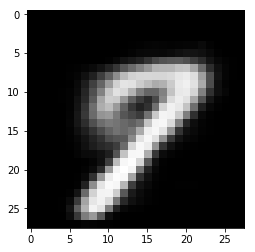

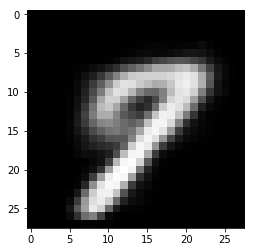

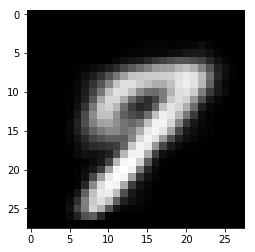

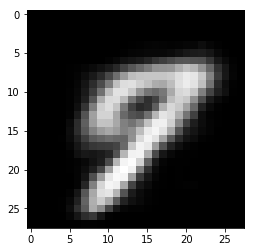

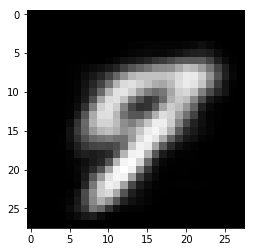

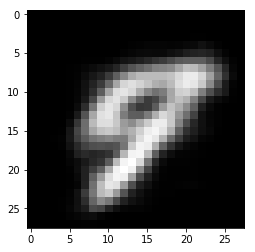

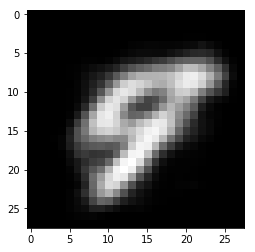

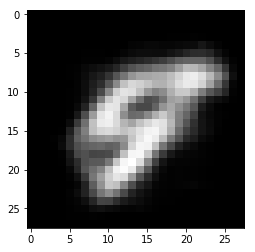

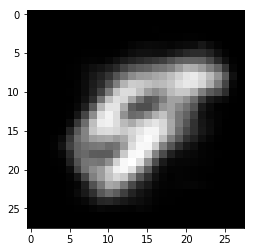

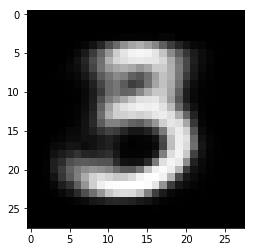

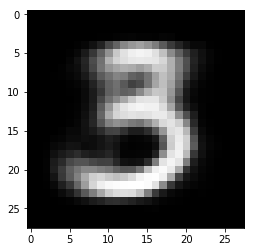

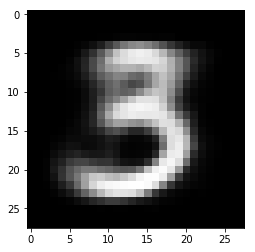

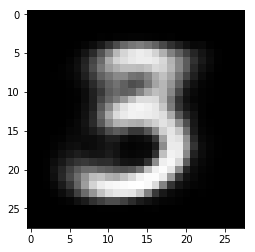

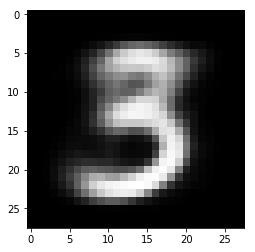

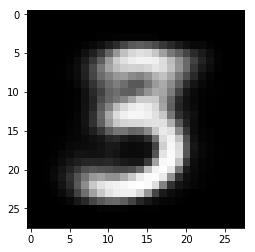

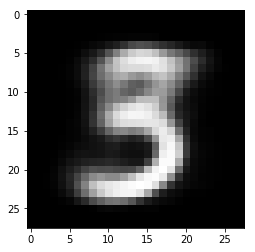

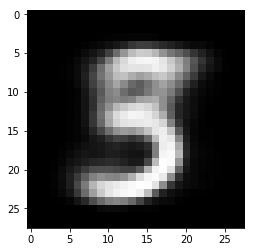

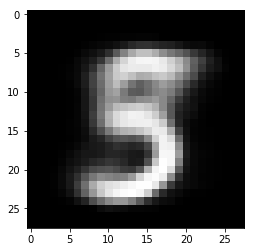

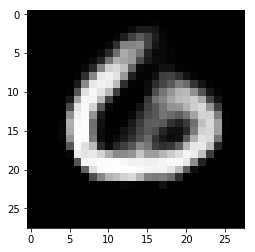

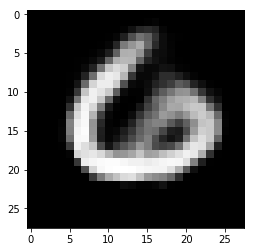

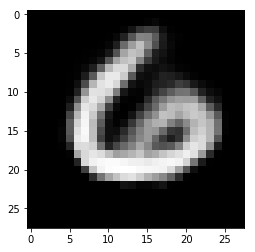

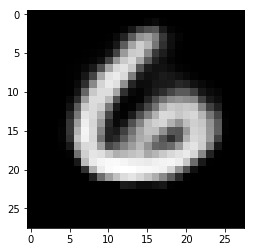

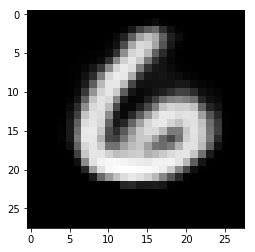

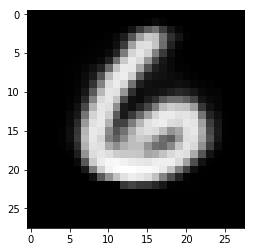

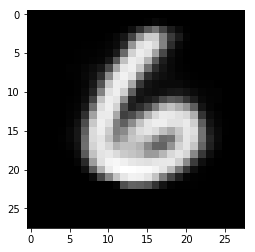

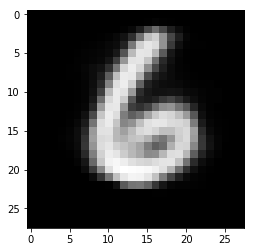

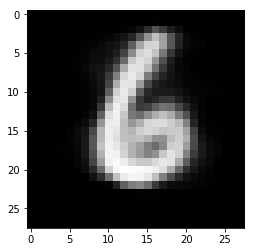

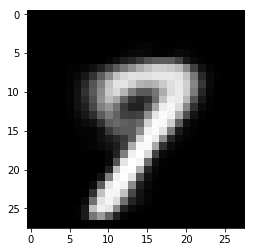

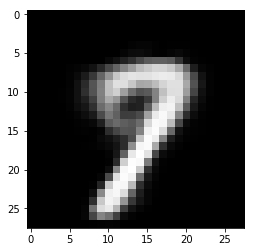

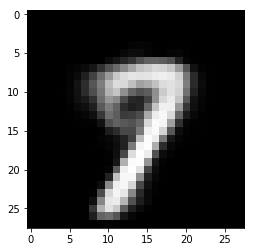

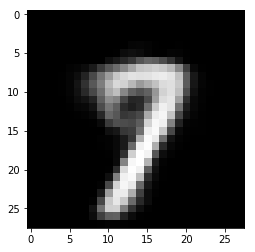

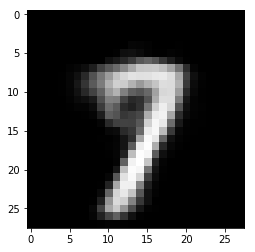

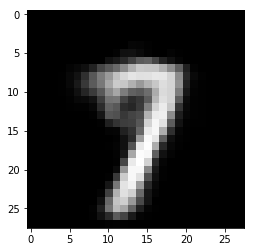

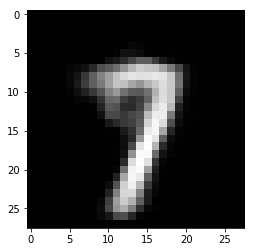

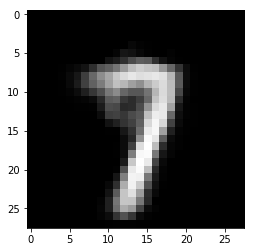

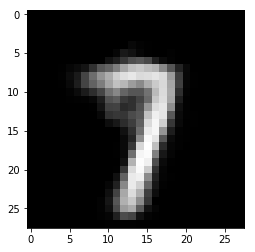

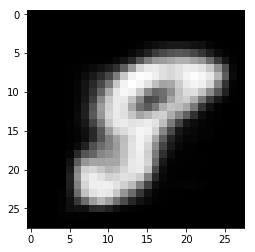

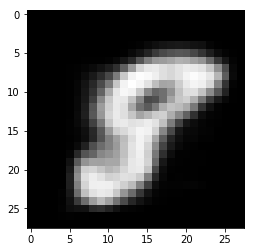

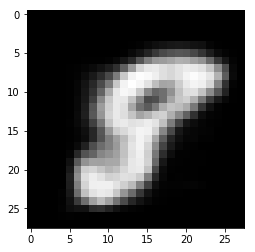

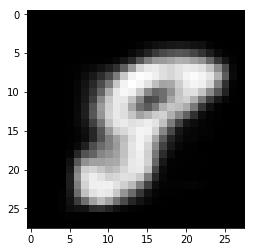

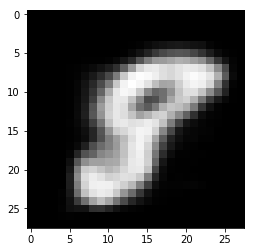

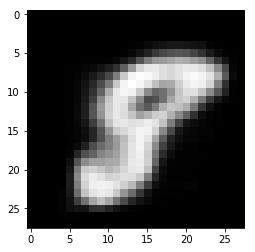

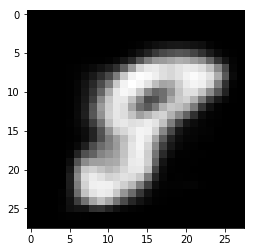

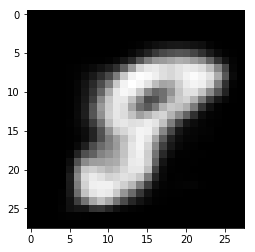

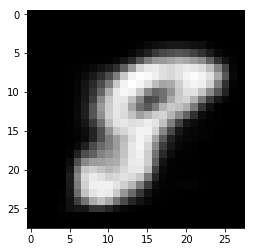

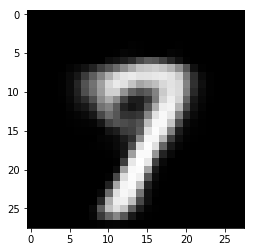

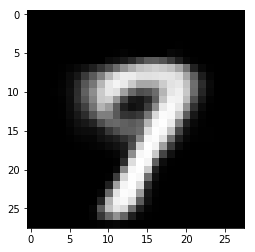

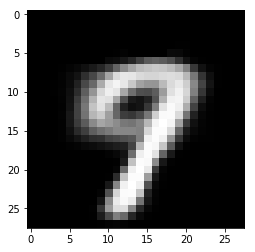

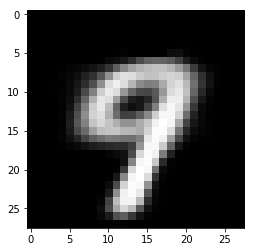

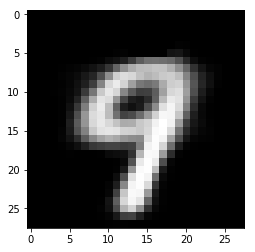

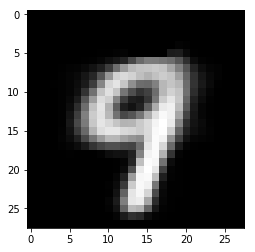

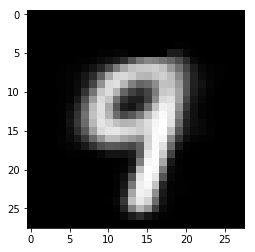

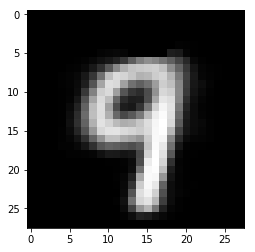

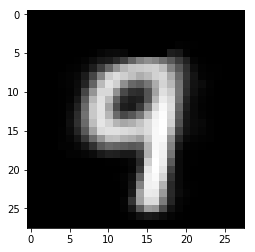

In [273]:
for num in largeCodesArr:
    for digit in num:
        decoded = decoder.predict(digit)
        plt.imshow(decoded.reshape(28,28),cmap='Greys_r')
        plt.show()
    

In [ ]:
largeCodesArr[9]

In [249]:
(codeSecond-codeFirst)

array([[-0.18593693,  1.2509121 ]], dtype=float32)

In [283]:
import numpy as np
import random

numbers = [0,1,2,3,4,5,6,7,8,9]
largeCodesArr =[]
for num in numbers:
    firstidx = random.choice(np.argwhere(np.array(y_test)==num))
    second = random.choice(np.argwhere(np.array(y_test)==num))
    first = x_test[firstidx]
    second = x_test[second]
    codeFirst = encoder.predict(first)[0]
    codeSecond = encoder.predict(second)[0]
    diff = codeSecond-codeFirst
    diffdiff = diff/8
    allCodes = []
#     allCodes.append(codeFirst)
    for i in range(0,9):
        temp = codeFirst+(i*diffdiff)
        allCodes.append(temp)
#     allCodes.append(codeSecond)
    largeCodesArr.append(allCodes)
#     decodedFirst = decoder.predict(codeFirst[0])

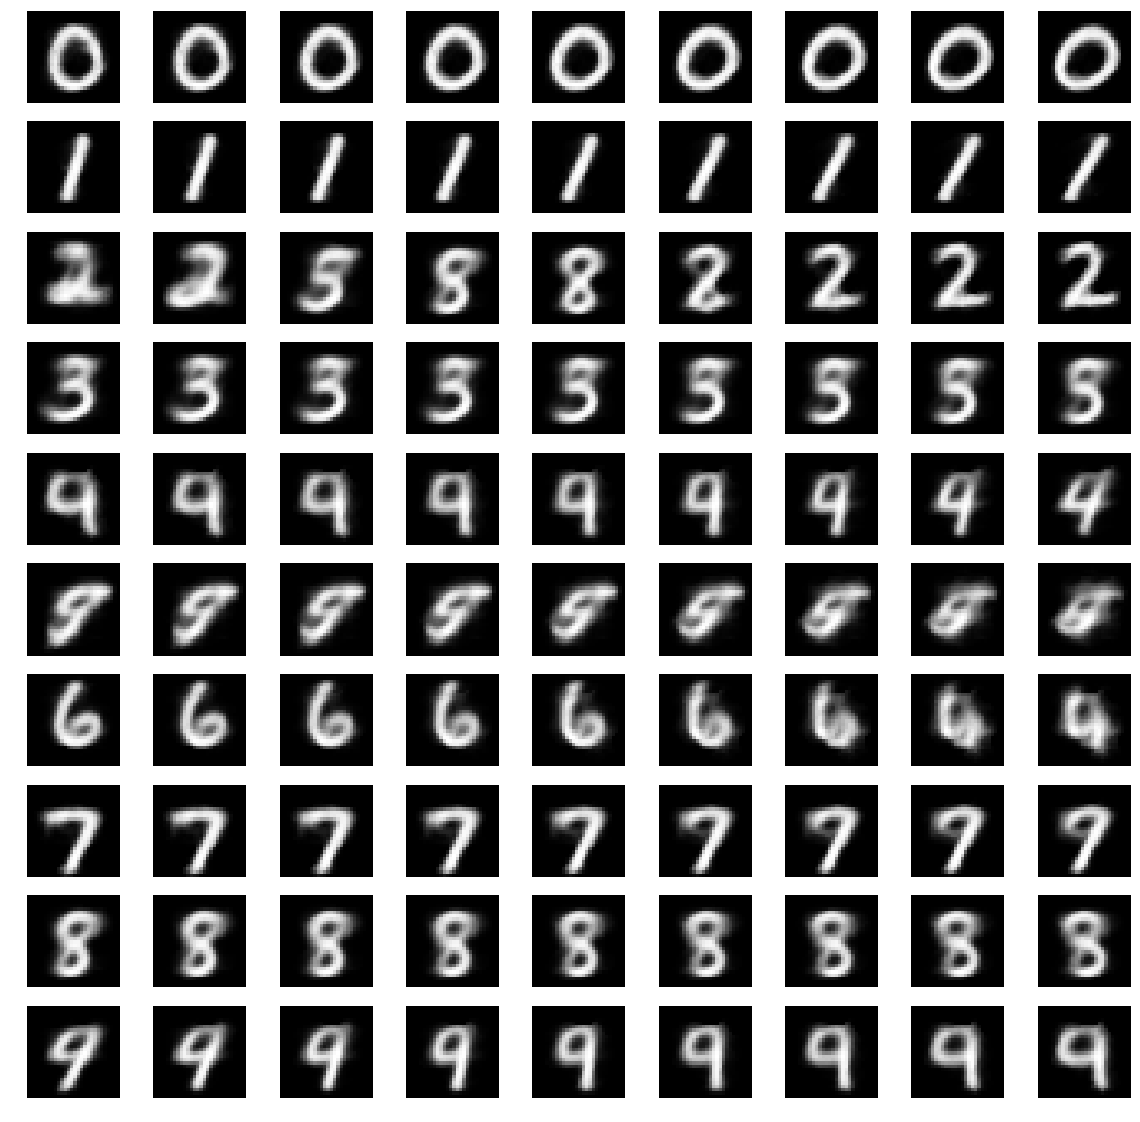

In [284]:
f,ax = plt.subplots(10,9,figsize=(20,20))
plt.axis('off')


for i,num in enumerate(largeCodesArr,0):
    for j,digit in enumerate(num,0):
        decoded = decoder.predict(digit)
        ax[i,j].imshow(decoded.reshape(28,28),cmap='Greys_r')
#         plt.show()
        ax[i,j].axis('off')

In [285]:
random.choice(numbers)

5

In [286]:
import numpy as np
import random

numbers = [0,1,2,3,4,5,6,7,8,9]
largeCodesArr =[]
for num in numbers:
    whichfirst = random.choice(numbers)
    whichsecond = random.choice(numbers)
    firstidx = random.choice(np.argwhere(np.array(y_test)==whichfirst))
    second = random.choice(np.argwhere(np.array(y_test)==whichsecond))
    first = x_test[firstidx]
    second = x_test[second]
    codeFirst = encoder.predict(first)[0]
    codeSecond = encoder.predict(second)[0]
    diff = codeSecond-codeFirst
    diffdiff = diff/8
    allCodes = []
#     allCodes.append(codeFirst)
    for i in range(0,9):
        temp = codeFirst+(i*diffdiff)
        allCodes.append(temp)
#     allCodes.append(codeSecond)
    largeCodesArr.append(allCodes)
#     decodedFirst = decoder.predict(codeFirst[0])
f,ax = plt.subplots(10,9,figsize=(20,20))
plt.axis('off')


for i,num in enumerate(largeCodesArr,0):
    for j,digit in enumerate(num,0):
        decoded = decoder.predict(digit)
        ax[i,j].imshow(decoded.reshape(28,28),cmap='Greys_r')
#         plt.show()
        ax[i,j].axis('off')

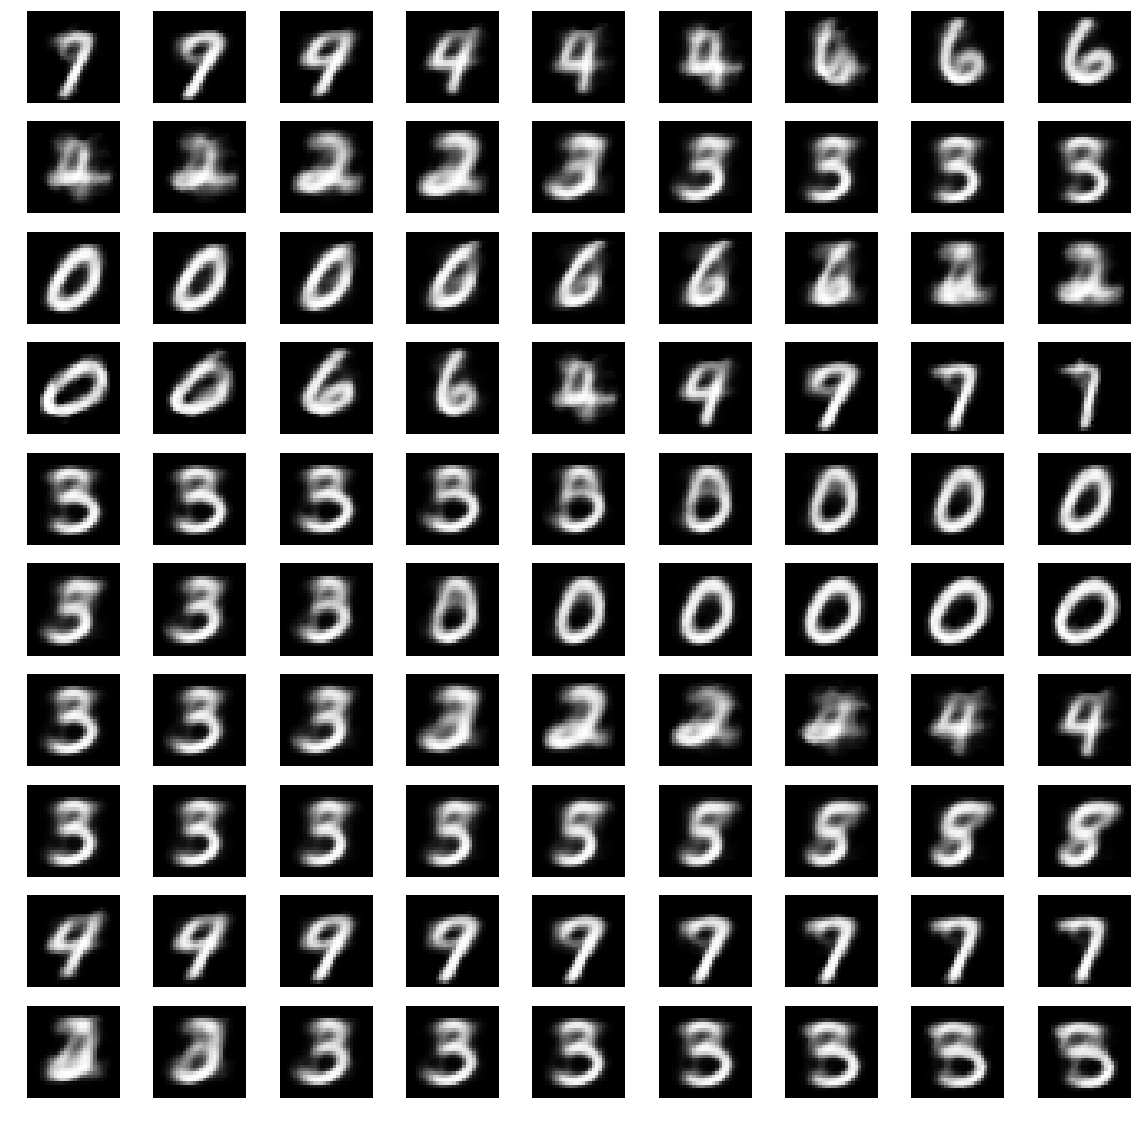